In [16]:
#impoting libraries---
# we are using neural network -- resnet50
from tensorflow.keras.layers import Input ,Lambda , Dense , Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [17]:
#Image Resizing--
IMAGE_SIZE = [224 , 224]

train_path = 'Datasets/train'
valid_path = 'Datasets/test'

In [18]:
#Importing resnet 50 library and add preprocessing layer to front of it
# we are using imagenets weights
## we add +3 to image size becoz height and width = (224,224), and we have to add 3 channels RGB
# include_top = false ,coz  we have only three classification and we are giving input from our side. so no need of first and last layers.
resnet = ResNet50(input_shape = IMAGE_SIZE + [3] , weights ='imagenet' , include_top=False)

In [19]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [20]:
# Don't train existing weight , only train top layers , reuse the trained weights to resnet
for layer in resnet.layers:
    layer.trainable = False

In [21]:
# useful for getting number of output classes ----we have 3 outputs so for training last layer
folders = glob('Datasets/train/*')

In [22]:
folders

['Datasets/train\\audi',
 'Datasets/train\\lamborghini',
 'Datasets/train\\mercedes']

In [24]:
# our layers -we can add more if we want
#flattening of the last layer
x = Flatten()(resnet.output)

In [27]:
# setting lenth of the model as output-----becoz output categories are 3
prediction = Dense(len(folders) , activation ='softmax')(x)

# create a model object
model = Model(inputs =resnet.input , outputs = prediction)


In [28]:
#view structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [29]:
#tell the model what cost and optimization method to use--
model.compile(
     loss ='categorical_crossentropy',
     optimizer='adam',
     metrics =['accuracy']
)

In [30]:
#Use the image data genrator to import the images from the dataset --- data aug never done in test data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range =0.2,
                                   zoom_range =0.2,
                                   horizontal_flip= True)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [31]:
# Reading the train dataset
#make sure you provide the same target size as initialized for image size
#categotical class mode is used coz , output has more than two feature , if they are two then we can use binary
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                target_size = (224,224),
                                                batch_size= 32,
                                                class_mode ='categorical')

Found 64 images belonging to 3 classes.


In [32]:
test_set = test_datagen.flow_from_directory('Datasets/test',
                                                target_size = (224,224),
                                                batch_size= 32,
                                                class_mode ='categorical')

Found 58 images belonging to 3 classes.


In [33]:
#fit the model
# Run the cell it will take time to execute
r = model.fit_generator(
     training_set,
     validation_data=test_set,
      epochs = 50,
     steps_per_epoch=len(training_set),
     validation_steps = len(test_set))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
2/2 [==============================] - 10s 5s/step - loss: 7.2228 - accuracy: 0.3594 - val_loss: 9.2341 - val_accuracy: 0.1552
Epoch 2/50
2/2 [==============================] - 8s 4s/step - loss: 6.4029 - accuracy: 0.3594 - val_loss: 4.3653 - val_accuracy: 0.3276
Epoch 3/50
2/2 [==============================] - 8s 4s/step - loss: 6.6386 - accuracy: 0.4531 - val_loss: 5.7191 - val_accuracy: 0.5172
Epoch 4/50
2/2 [==============================] - 8s 4s/step - loss: 7.1569 - accuracy: 0.3594 - val_loss: 3.5199 - val_accuracy: 0.3276
Epoch 5/50
2/2 [==============================] - 8s 4s/step - loss: 3.2740 - accuracy: 0.3906 - val_loss: 5.1554 - val_accuracy: 0.1552
Epoch 6/50
2/2 [==============================] - 8s 4s/step - loss: 4.1958 - accuracy: 0.3906 - val_loss: 6.2354 - val_accuracy: 0.1552
Epoch 7/50
2/2 [==============================] - 8s 4s/step - loss: 3.0813 - accuracy: 0.3906 - val_

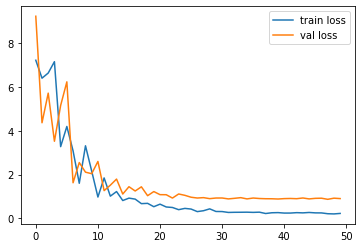

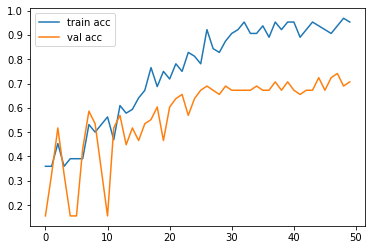

<Figure size 432x288 with 0 Axes>

In [34]:

# TO iMPROVE VALIDATION ACCURACY---INCREASE SIZE OF DATASET
#plot the loss
plt.plot(r.history['loss'], label ='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

#plot the accuracy
plt.plot(r.history['accuracy'], label ='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [35]:
# SAVE THE MODEL AS A h5  FILE

from tensorflow.keras.models import load_model
model.save('model_resnet50.h5')

In [36]:
y_pred = model.predict(test_set)

In [37]:
y_pred

array([[9.82950041e-06, 1.14224129e-03, 9.98847961e-01],
       [2.52236966e-02, 6.60222888e-01, 3.14553410e-01],
       [3.30091476e-01, 3.63398314e-01, 3.06510270e-01],
       [2.43322342e-03, 6.92767978e-01, 3.04798871e-01],
       [3.57518122e-02, 6.25017762e-01, 3.39230508e-01],
       [3.54140587e-02, 4.56768095e-01, 5.07817864e-01],
       [6.83078403e-03, 9.81680930e-01, 1.14882253e-02],
       [3.53468545e-02, 9.62519884e-01, 2.13326653e-03],
       [6.83219731e-01, 1.72292218e-01, 1.44488066e-01],
       [9.82426922e-04, 9.75550890e-01, 2.34666355e-02],
       [4.67229746e-02, 7.13793814e-01, 2.39483148e-01],
       [1.80801599e-05, 1.41277385e-04, 9.99840617e-01],
       [7.11584166e-02, 4.08857316e-01, 5.19984245e-01],
       [1.48460135e-01, 3.54396994e-03, 8.47995937e-01],
       [8.89024377e-01, 1.07575238e-01, 3.40040913e-03],
       [5.41562848e-02, 8.60924572e-02, 8.59751284e-01],
       [2.50718705e-02, 8.48103166e-01, 1.26825020e-01],
       [6.98993027e-01, 1.06988

In [47]:
## these three columns are of three different categories we have--and we take max value from that
import numpy as np
y_pred = np.argmax(y_pred , axis=1)

In [48]:
y_pred

array([2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 2, 2, 2, 0, 2, 1, 0, 0, 2, 2, 1,
       1, 1, 2, 1, 1, 2, 2, 0, 0, 2, 1, 2, 2, 1, 1, 2, 0, 2, 2, 1, 1, 1,
       0, 1, 1, 1, 1, 2, 2, 0, 0, 2, 2, 2, 2, 1], dtype=int64)

In [49]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [50]:
model = load_model('model_resnet50.h5')

In [54]:
#working on test data
img = image.load_img('Datasets/Test/lamborghini/10.jpg' , target_size=(224,224))

In [55]:
# it is important to convert an image to array
x= image.img_to_array(img)
x

array([[[ 17.,   7.,   0.],
        [ 17.,   7.,   0.],
        [ 17.,   7.,   0.],
        ...,
        [ 13.,   2.,   0.],
        [ 14.,   4.,   3.],
        [ 14.,   4.,   3.]],

       [[ 17.,   7.,   0.],
        [ 17.,   7.,   0.],
        [ 18.,   8.,   0.],
        ...,
        [ 14.,   3.,   1.],
        [ 14.,   4.,   3.],
        [ 14.,   4.,   3.]],

       [[ 18.,   8.,   0.],
        [ 18.,   8.,   0.],
        [ 19.,   9.,   0.],
        ...,
        [ 14.,   3.,   1.],
        [ 14.,   4.,   3.],
        [ 14.,   4.,   3.]],

       ...,

       [[209., 129.,  92.],
        [210., 130.,  93.],
        [212., 132.,  95.],
        ...,
        [216., 132.,  96.],
        [214., 129.,  92.],
        [213., 129.,  92.]],

       [[208., 128.,  91.],
        [208., 128.,  91.],
        [211., 131.,  94.],
        ...,
        [215., 131.,  95.],
        [209., 129.,  94.],
        [207., 129.,  93.]],

       [[206., 128.,  90.],
        [206., 128.,  90.],
        [209., 1

In [56]:
x.shape

(224, 224, 3)

In [57]:
x=x/225

In [58]:
x= np.expand_dims(x,axis = 0) ## to make dimension as output
img_data =preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [59]:
model.predict(img_data)

array([[0.4178276 , 0.01522834, 0.566944  ]], dtype=float32)

In [60]:
a = np.argmax(model.predict(img_data), axis =1)

In [61]:
a

array([2], dtype=int64)